# Varibaility
This notebook is for plotting:

- **Figure 6**: Changes in varibaility
- **Supplementary Figure 6**: Changes in variability in summer
- **Supplementary Figure 7**: Changes in variability in summer normalized over PD

requires running select_EDWs.py first

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np

In [3]:
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia','Baltic', 'Eastern']
abr = ['NRD', 'BRI', 'NWE', 'CEN', 'IBA', 'BAL', 'EAS']
values = [['NOR', 'SWE', 'FIN'],
           ['GBR',  'IRL'],
           ['DNK', 'DEU', 'NLD', 'BEL'],
           ['FRA', 'ITA', 'CHE', 'AUT'],
           ['ESP', 'PRT'],
           ['EST', 'LVA', 'LTU'],
           ['POL', 'HRV', 'HUN', 'CZE', 'SVN', 'SVK']
          ]

def get_events(ds,df):
    selected_data = []
    # Iterate through each row in the DataFrame to access the event details
    for c in df.region.unique():
        country_events = []
        dfc = df.loc[df.region == c]
        for idx, event in dfc.iterrows():
            # Access data for the specific run, country, and time range
            data_slice = ds.sel(runs=event['runs'],
                                region=event['region'],
                                time=slice(event['ts0'], event['tsn']))
            
            # Append the sliced data to the list
            country_events.append(data_slice)
        selected_data.append(xr.concat(country_events, dim='event'))
        # Combine all selected data slices into a single dataset
    return xr.concat(selected_data, dim='region')

def compute_summed_productions(ds):
    ds['wind'] = ds['wind_onshore']+ds['wind_offshore']
    ds['hydro'] = ds['ror']+ds['Eout']
    ds['pv'] = ds['pv_util']
    return ds


def compute_mean_and_std(ds, timestep):
    groups = ds.stack(z=('runs', 'time')).groupby(timestep)
    means = groups.mean()
    ds_anom = groups - means
    std = ds_anom[metrics].std(dim='z')
    
    return means, std

def compute_monthly_mean_std(ds):
    dsm = ds.resample(time='1M').mean()
    monthly_means, std = compute_mean_and_std(dsm, 'time.month')
    return monthly_means, std

# def compute_yearly_mean_std(ds):
#     dsm = ds.resample(time='1Y').mean()
#     monthly_means, std = compute_mean_and_std(dsm, 'time.year')
#     return monthly_means, std

def compute_yearly_mean_std(ds, drop_years = True):
    dsm = ds.resample(time='1Y').mean()
    if drop_years:
        dsm = dsm.isel(time=[1,2,3,4,5,6,7,8])
    monthly_means, std = compute_mean_and_std(dsm, 'time.year')
    return monthly_means, std

def compute_shifted_yearly_mean_std(ds):
    # Add 'month' coordinate if not already present
    if 'month' not in ds.coords:
        ds.coords['month'] = ds.time.dt.month
    
    # Shift time index by -3 months to start the year from October 1
    shifted_time = ds.time.to_index() + pd.DateOffset(months=3)  # Shift by 3 months
    
    # Create a new coordinate for time with the shifted time values
    ds.coords['time'] = shifted_time
    
    # Compute yearly mean and std based on the new time shift
    yearly_means, std = compute_yearly_mean_std(ds, drop_years=True)
    return yearly_means, std

def flatten(xss):
    return [x for xs in xss for x in xs]

def to_melted_df(ds, scenario_name):
    df = ds.to_dataframe().reset_index()
    df['scenario'] = scenario_name
    df = df.melt(id_vars = ['region', 'scenario'],
              value_vars=['pv', 'wind', 'hydro', 'demand', 'residual'],
              var_name = 'var',
              value_name = 'value'
             )
    return df

def print_min_max(df, ts):
    df = df.pivot(index=['scenario', 'region'], columns='var', values='value')
    # Subtract `present-day` from `future`
    result = df.loc["future"] - df.loc["present-day"]
    # print min result
    print(f'{ts} min:', result[result == result.min().min()].stack().index[0], result.min().min())
    print(f'{ts} max:', result[result == result.max().max()].stack().index[0], result.max().max())



In [5]:
# open files
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions = ds_regions.compute()
region_files = glob.glob(f'*_FU.nc')
ds_regions_future = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions_future = ds_regions_future.compute()

# check for events
return_period = 10
season_listfu = []
season_listpd = []
for season in ['DJF', 'MAM', 'JJA', 'SON']:
    # open events

    df_pd = pd.read_csv(f'residual_el30_{season}_LENTIS_2023_PD2.csv', index_col=0)
    df_pd = df_pd.rename({'country':'region'}, axis=1)
    df_pd['region'] = df_pd['region'].map({k:v for k,v in zip(abr,keys)})
    df_pd = df_pd.where(df_pd.event_nr < 321).dropna()
    # selecting events:
    dsevents_pd = get_events(ds_regions,df_pd)
    dsevents_pd['event'] = np.arange(1,len(dsevents_pd.event)+1)
    dsevents_meanpd = dsevents_pd[['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']].sel(event = np.arange(1,(1600/return_period)+1))#.mean(dim=['time', 'event'])
    season_listpd.append(dsevents_meanpd)
    # Now 'combined_data' contains all the slices corresponding to events in your DataFrame

    # open events
    df_fu = pd.read_csv(f'residual_el30_{season}_LENTIS_2023_FU.csv', index_col=0)
    df_fu = df_fu.rename({'country':'region'}, axis=1)
    df_fu['region'] = df_fu['region'].map({k:v for k,v in zip(abr,keys)})
    df_fu = df_fu.where(df_fu.event_nr < 321).dropna()
    ## selecting events:
    dsevents_fu = get_events(ds_regions_future,df_fu)
    dsevents_fu['event'] = np.arange(1,len(dsevents_fu.event)+1)
    # Now 'combined_data' contains all the slices corresponding to events in your DataFrame
    dsevents_mean = dsevents_fu[['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']].sel(event = np.arange(1,(1600/return_period)+1))#.mean(dim=['time', 'event'])
    season_listfu.append(dsevents_mean)
dsseason_fu = xr.concat(season_listfu, dim='season')
dsseason_fu['season'] = ['DJF', 'MAM', 'JJA', 'SON']
dsseason_pd = xr.concat(season_listpd, dim='season')
dsseason_pd['season'] = ['DJF', 'MAM', 'JJA', 'SON']

In [6]:
ds = dsseason_pd.sel(season='DJF')
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')

ds_monthly_var = (ds_std/ds.mean(dim='event'))*100
to_melted_df(ds_monthly_var, 'PD')

,region,scenario,var,value
0,Nordic,PD,pv,46.522252
1,British Isles,PD,pv,30.053097
2,North Western,PD,pv,31.039025
3,Central,PD,pv,16.545731
4,Iberia,PD,pv,9.482286
5,Baltic,PD,pv,41.333074
6,Eastern,PD,pv,27.869950
7,Nordic,PD,wind,16.354664
8,British Isles,PD,wind,21.002359
9,North Western,PD,wind,17.716257


daily min: ('Iberia', 'wind') -6.242640623648683
daily max: ('North Western', 'hydro') 6.407698944221785
monthly min: ('Iberia', 'wind') -2.6071685440782773
monthly max: ('North Western', 'hydro') 4.116914661347842
yearly min: ('Eastern', 'pv') -1.2333529358808004
yearly max: ('Baltic', 'hydro') 4.6563414944621115
extremes min: ('Baltic', 'hydro') -13.405502734242376
extremes max: ('North Western', 'hydro') 4.216213945949775


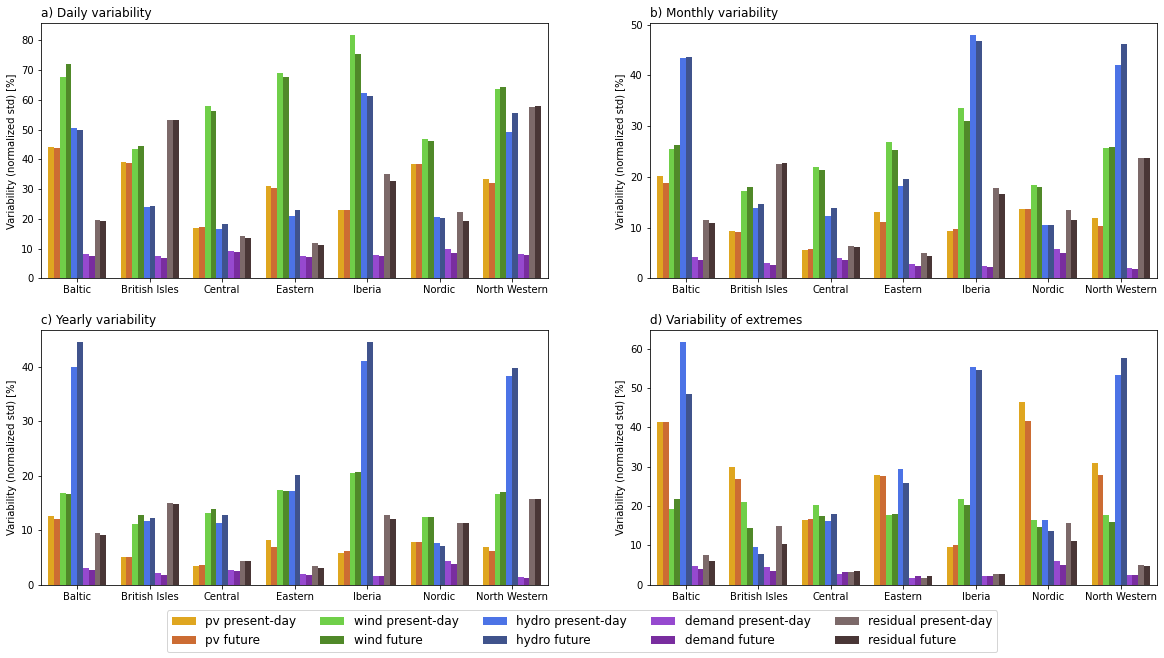

In [67]:
# open files
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
PD = ds_regions.compute()
PD = compute_summed_productions(PD)
PD = PD.sel(time=PD.time.dt.month.isin((12,1,2)))

region_files = glob.glob(f'*_FU.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
FU = compute_summed_productions(ds_regions)
FU = FU.compute()
FU = FU.sel(time=FU.time.dt.month.isin((12,1,2)))

# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# ----------------
## Daily
# ----------------

ax = axs[0]
ax.set_title('a) Daily variability', ha='left', x=0)
daily_means_pd, std_pd = compute_mean_and_std(PD[metrics], 'time.dayofyear')
daily_var_pd = (std_pd / daily_means_pd.mean(dim='dayofyear')) * 100
df_pd = to_melted_df(daily_var_pd, 'present-day')
df_pd = df_pd.fillna(0)

daily_means, std = compute_mean_and_std(FU[metrics], 'time.dayofyear')
daily_var = (std / daily_means_pd.mean(dim='dayofyear')) * 100
df_fu = to_melted_df(daily_var, 'future')


df = pd.concat([df_pd, df_fu], ignore_index=True)
df = df.fillna(0)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

custom_order = [f for v in metrics for f in df.newvarname.unique() if v in f]

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

df = df.pivot(index=['scenario', 'region'], columns='var', values='value')
# Subtract `present-day` from `future`
result = df.loc["future"] - df.loc["present-day"]
# print min result
print('daily min:', result[result == result.min().min()].stack().index[0], result.min().min())
print('daily max:', result[result == result.max().max()].stack().index[0], result.max().max())

# ----------------
## Monthly
# ----------------
ax = axs[1]
ax.set_title('b) Monthly variability', ha='left', x=0)
monthly_means_pd, std_pd = compute_monthly_mean_std(PD[metrics])
monthly_var_pd = (std_pd / monthly_means_pd.mean(dim='month')) * 100
df_pd = to_melted_df(monthly_var_pd, 'present-day')

monthly_means_fu, std_fu = compute_monthly_mean_std(FU[metrics])
monthly_var_fu = (std_fu / monthly_means_pd.mean(dim='month')) * 100
df_fu = to_melted_df(monthly_var_fu, 'future')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)
df = df.pivot(index=['scenario', 'region'], columns='var', values='value')
# Subtract `present-day` from `future`
result = df.loc["future"] - df.loc["present-day"]
# print min result
print('monthly min:', result[result == result.min().min()].stack().index[0], result.min().min())
print('monthly max:', result[result == result.max().max()].stack().index[0], result.max().max())

# ----------------
## Yearly
# ----------------
ax = axs[2]
ax.set_title('c) Yearly variability', ha='left', x=0)
yearly_means_pd, std_pd = compute_shifted_yearly_mean_std(PD[metrics])
yearly_var_pd = (std_pd / yearly_means_pd.mean(dim='year')) * 100
df_pd = to_melted_df(yearly_var_pd, 'present-day')

yearly_means_fu, std_fu = compute_shifted_yearly_mean_std(FU[metrics])
yearly_var_fu = (std_fu / yearly_means_fu.mean(dim='year')) * 100
df_fu = to_melted_df(yearly_var_fu, 'future')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

df = df.pivot(index=['scenario', 'region'], columns='var', values='value')
# Subtract `present-day` from `future`
result = df.loc["future"] - df.loc["present-day"]
# print min result
print('yearly min:', result[result == result.min().min()].stack().index[0], result.min().min())
print('yearly max:', result[result == result.max().max()].stack().index[0], result.max().max())
# ----------------
## Extremes
# ----------------
ax = axs[3]
ax.set_title('d) Variability of extremes', ha='left',x=0)
# extreme_means_pd, std_pd = compute_yearly_mean_std(PD[metrics])
# extreme_var_pd = (std_pd / extreme_means_pd.mean(dim='year')) * 100
# df_pd = to_melted_df(extreme_var_pd, 'PD')
# presemt
ds = dsseason_pd.sel(season='DJF').fillna(0)
ds = compute_summed_productions(ds)
dspd = ds.sum(dim='time')
ds_anom = dspd - dspd.mean(dim='event')
ds_std = dspd.std(dim='event')
ds_monthly_var = (ds_std/dspd.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_pd = to_melted_df(ds_monthly_var, 'present-day')
# future
ds = dsseason_fu.sel(season='DJF').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')

ds_monthly_var = (ds_std/dspd.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_fu = to_melted_df(ds_monthly_var, 'future')


# df_fu = to_melted_df(extreme_var_fu, '2K')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)
df = df.pivot(index=['scenario', 'region'], columns='var', values='value')
# Subtract `present-day` from `future`
result = df.loc["future"] - df.loc["present-day"]
# print min result
print('extremes min:', result[result == result.min().min()].stack().index[0], result.min().min())
print('extremes max:', result[result == result.max().max()].stack().index[0], result.max().max())

# Set shared ylabel for all subplots
for ax in axs:
    ax.set_ylabel('Variability (normalized std) [%]')
    ax.set_xlabel('')
    ax.legend_.remove()  # Remove individual legends

# Create a shared legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=12)

# Adjust layout to make room for the shared legend
plt.subplots_adjust(bottom=0.1)

plt.savefig(f'figure5_variability_winter_relative_to_pd.png', dpi=300, bbox_inches='tight')
  
plt.show()


In [ ]:

# open files
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
PD = ds_regions.compute()
PD = compute_summed_productions(PD)
PD = PD.sel(time=PD.time.dt.month.isin((12,1,2)))

region_files = glob.glob(f'*_FU.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
FU = compute_summed_productions(ds_regions)
FU = FU.compute()
FU = FU.sel(time=FU.time.dt.month.isin((12,1,2)))


# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# ----------------
## Daily
# ----------------


ax = axs[0]
ax.set_title('a) Daily variability', ha='left', x=0)
daily_means_pd, std_pd = compute_mean_and_std(PD[metrics], 'time.dayofyear')
daily_var_pd = (std_pd / daily_means_pd.mean(dim='dayofyear')) * 100
df_pd = to_melted_df(daily_var_pd, 'present-day')
df_pd = df_pd.fillna(0)

daily_means, std = compute_mean_and_std(FU[metrics], 'time.dayofyear')
daily_var = (std / daily_means.mean(dim='dayofyear')) * 100
df_fu = to_melted_df(daily_var, 'future')


df = pd.concat([df_pd, df_fu], ignore_index=True)
df = df.fillna(0)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

custom_order = [f for v in metrics for f in df.newvarname.unique() if v in f]

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Monthly
# ----------------
ax = axs[1]
ax.set_title('b) Monthly variability', ha='left', x=0)
monthly_means_pd, std_pd = compute_monthly_mean_std(PD[metrics])
monthly_var_pd = (std_pd / monthly_means_pd.mean(dim='month')) * 100
df_pd = to_melted_df(monthly_var_pd, 'present-day')

monthly_means_fu, std_fu = compute_monthly_mean_std(FU[metrics])
monthly_var_fu = (std_fu / monthly_means_fu.mean(dim='month')) * 100
df_fu = to_melted_df(monthly_var_fu, 'future')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Yearly
# ----------------
ax = axs[2]
ax.set_title('c) Yearly variability', ha='left', x=0)

# Compute the yearly mean and standard deviation for present-day (PD)
yearly_means_pd, std_pd = compute_shifted_yearly_mean_std(PD[metrics])
yearly_var_pd = (std_pd / yearly_means_pd.mean(dim='year')) * 100
df_pd = to_melted_df(yearly_var_pd, 'present-day')

# Compute the yearly mean and standard deviation for future (FU)
yearly_means_fu, std_fu = compute_shifted_yearly_mean_std(FU[metrics])
yearly_var_fu = (std_fu / yearly_means_fu.mean(dim='year')) * 100
df_fu = to_melted_df(yearly_var_fu, 'future')

# Combine the present-day and future data
df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

# Create the bar plot with the updated variable names
sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)
# ----------------
## Extremes
# ----------------
ax = axs[3]
ax.set_title('d) Variability of extremes', ha='left', x=0)
# extreme_means_pd, std_pd = compute_yearly_mean_std(PD[metrics])
# extreme_var_pd = (std_pd / extreme_means_pd.mean(dim='year')) * 100
# df_pd = to_melted_df(extreme_var_pd, 'PD')
# presemt
ds = dsseason_pd.sel(season='DJF').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')
ds_monthly_var = (ds_std/ds.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_pd = to_melted_df(ds_monthly_var, 'present-day')
# future
ds = dsseason_fu.sel(season='DJF').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')

ds_monthly_var = (ds_std/ds.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_fu = to_melted_df(ds_monthly_var, 'future')


# df_fu = to_melted_df(extreme_var_fu, '2K')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# Set shared ylabel for all subplots
for ax in axs:
    ax.set_ylabel('Variability (normalized std) [%]')
    ax.set_xlabel('')
    ax.legend_.remove()  # Remove individual legends

# Create a shared legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=12)

# Adjust layout to make room for the shared legend
plt.subplots_adjust(bottom=0.1)

plt.savefig(f'figure5_variability_winter.png', dpi=300, bbox_inches='tight')
  
plt.show()


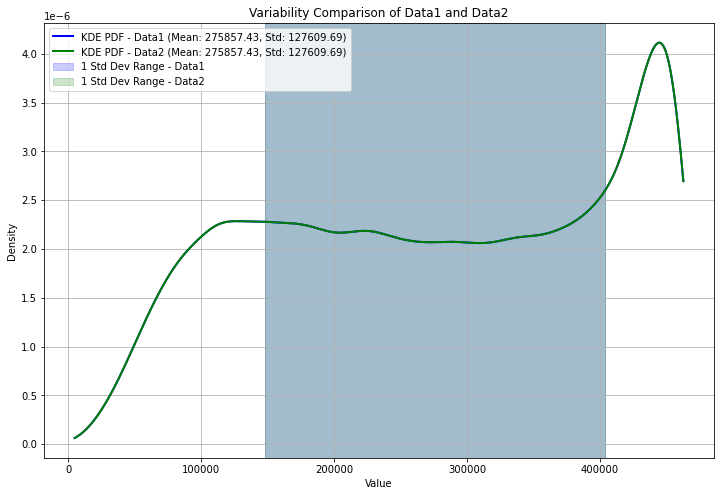

0.0


In [66]:
# explain wind variability increase:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate or load your datasets
data1 = ds_regions.sel(region='British Isles').sel(time=ds_regions.time.dt.month.isin((12,1,2))).wind_onshore.values
data1 = data1.flatten()

data2 = ds_regions_future.sel(region='British Isles').sel(time=ds_regions.time.dt.month.isin((12,1,2))).wind_onshore.values
data2 = data2.flatten()

# Calculate statistics
mean1, std1 = np.mean(data1), np.std(data1)
mean2, std2 = np.mean(data2), np.std(data2)

# KDE for smoother PDFs
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

x_vals1 = np.linspace(min(data1), max(data1), 1000)
x_vals2 = np.linspace(min(data2), max(data2), 1000)
kde_vals1 = kde1(x_vals1)
kde_vals2 = kde2(x_vals2)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x_vals1, kde_vals1, label=f"KDE PDF - Data1 (Mean: {mean1:.2f}, Std: {std1:.2f})", linewidth=2, color='blue')
plt.plot(x_vals2, kde_vals2, label=f"KDE PDF - Data2 (Mean: {mean2:.2f}, Std: {std2:.2f})", linewidth=2, color='green')

# Highlight 1-std range for both datasets
plt.axvspan(mean1 - std1, mean1 + std1, color='blue', alpha=0.2, label='1 Std Dev Range - Data1')
plt.axvspan(mean2 - std2, mean2 + std2, color='green', alpha=0.2, label='1 Std Dev Range - Data2')

# Titles and labels
plt.title("Variability Comparison of Data1 and Data2")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

print(std2-std1)

# summer 

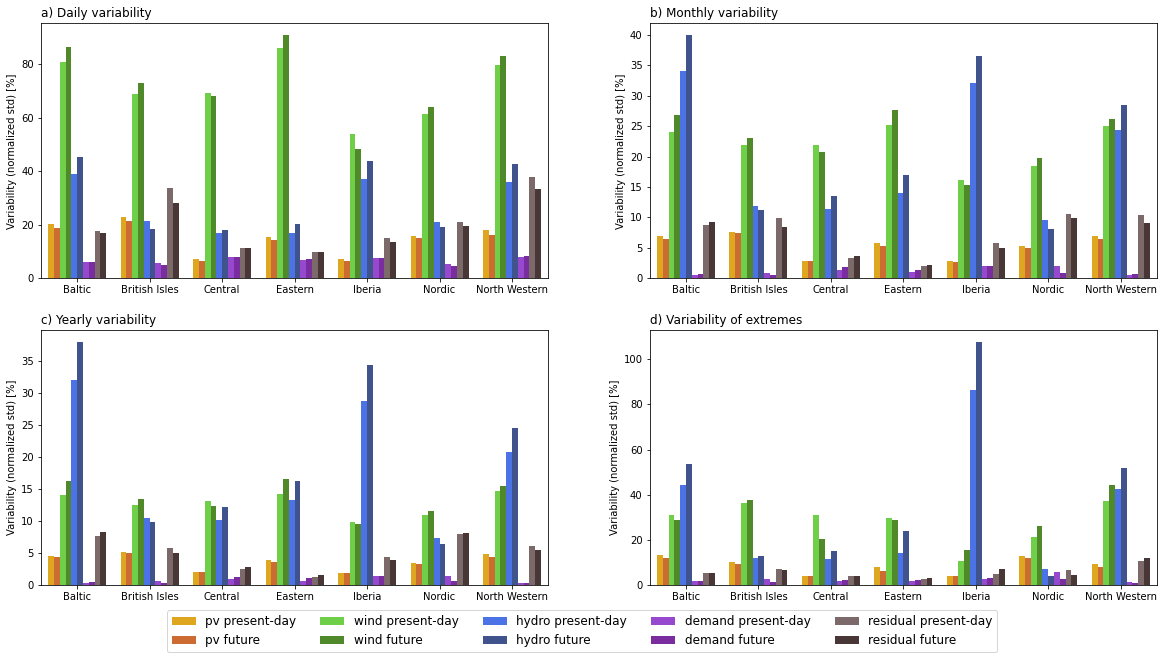

In [76]:

# open files
region_files = glob.glob(f'_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
PD = ds_regions.compute()
PD = compute_summed_productions(PD)
PD = PD.sel(time=PD.time.dt.month.isin((6,7,8)))

region_files = glob.glob(f'*_FU.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
FU = compute_summed_productions(ds_regions)
FU = FU.compute()
FU = FU.sel(time=FU.time.dt.month.isin((6,7,8)))


# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# ----------------
## Daily
# ----------------


ax = axs[0]
ax.set_title('a) Daily variability', ha='left', x=0)
daily_means_pd, std_pd = compute_mean_and_std(PD[metrics], 'time.dayofyear')
daily_var_pd = (std_pd / daily_means_pd.mean(dim='dayofyear')) * 100
df_pd = to_melted_df(daily_var_pd, 'present-day')
df_pd = df_pd.fillna(0)

daily_means, std = compute_mean_and_std(FU[metrics], 'time.dayofyear')
daily_var = (std / daily_means.mean(dim='dayofyear')) * 100
df_fu = to_melted_df(daily_var, 'future')


df = pd.concat([df_pd, df_fu], ignore_index=True)
df = df.fillna(0)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

custom_order = [f for v in metrics for f in df.newvarname.unique() if v in f]

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Monthly
# ----------------
ax = axs[1]
ax.set_title('b) Monthly variability', ha='left', x=0)
monthly_means_pd, std_pd = compute_monthly_mean_std(PD[metrics])
monthly_var_pd = (std_pd / monthly_means_pd.mean(dim='month')) * 100
df_pd = to_melted_df(monthly_var_pd, 'present-day')

monthly_means_fu, std_fu = compute_monthly_mean_std(FU[metrics])
monthly_var_fu = (std_fu / monthly_means_fu.mean(dim='month')) * 100
df_fu = to_melted_df(monthly_var_fu, 'future')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Yearly
# ----------------
ax = axs[2]
ax.set_title('c) Yearly variability', ha='left', x=0)

# Compute the yearly mean and standard deviation for present-day (PD)
yearly_means_pd, std_pd = compute_shifted_yearly_mean_std(PD[metrics])
yearly_var_pd = (std_pd / yearly_means_pd.mean(dim='year')) * 100
df_pd = to_melted_df(yearly_var_pd, 'present-day')

# Compute the yearly mean and standard deviation for future (FU)
yearly_means_fu, std_fu = compute_shifted_yearly_mean_std(FU[metrics])
yearly_var_fu = (std_fu / yearly_means_fu.mean(dim='year')) * 100
df_fu = to_melted_df(yearly_var_fu, 'future')

# Combine the present-day and future data
df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

# Create the bar plot with the updated variable names
sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)
# ----------------
## Extremes
# ----------------
ax = axs[3]
ax.set_title('d) Variability of extremes', ha='left', x=0)
# extreme_means_pd, std_pd = compute_yearly_mean_std(PD[metrics])
# extreme_var_pd = (std_pd / extreme_means_pd.mean(dim='year')) * 100
# df_pd = to_melted_df(extreme_var_pd, 'PD')
# presemt
ds = dsseason_pd.sel(season='JJA').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')
ds_monthly_var = (ds_std/ds.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_pd = to_melted_df(ds_monthly_var, 'present-day')
# future
ds = dsseason_fu.sel(season='JJA').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')

ds_monthly_var = (ds_std/ds.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_fu = to_melted_df(ds_monthly_var, 'future')


# df_fu = to_melted_df(extreme_var_fu, '2K')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# Set shared ylabel for all subplots
for ax in axs:
    ax.set_ylabel('Variability (normalized std) [%]')
    ax.set_xlabel('')
    ax.legend_.remove()  # Remove individual legends

# Create a shared legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=12)

# Adjust layout to make room for the shared legend
plt.subplots_adjust(bottom=0.1)

plt.savefig(f'figure5_variability_summer.png', dpi=300, bbox_inches='tight')
  
plt.show()


# summer relative to PD

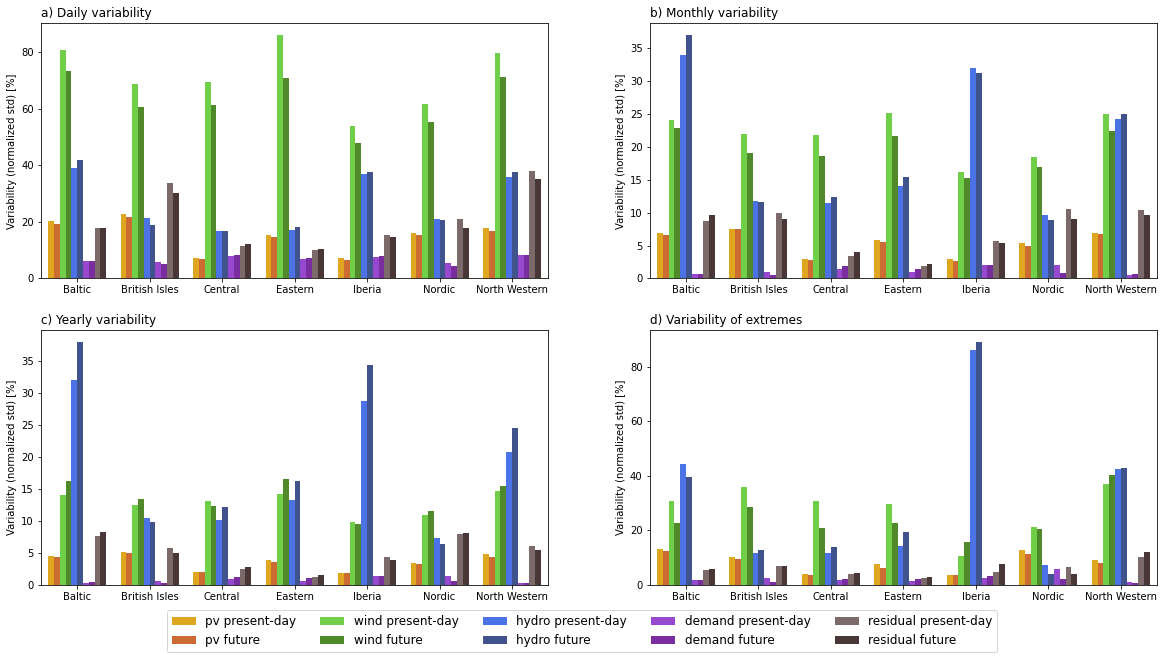

In [75]:
# open files
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
PD = ds_regions.compute()
PD = compute_summed_productions(PD)
PD = PD.sel(time=PD.time.dt.month.isin((6,7,8)))

region_files = glob.glob(f'*_FU.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
FU = compute_summed_productions(ds_regions)
FU = FU.compute()
FU = FU.sel(time=FU.time.dt.month.isin((6,7,8)))


# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# ----------------
## Daily
# ----------------


ax = axs[0]
ax.set_title('a) Daily variability', ha='left', x=0)
daily_means_pd, std_pd = compute_mean_and_std(PD[metrics], 'time.dayofyear')
daily_var_pd = (std_pd / daily_means_pd.mean(dim='dayofyear')) * 100
df_pd = to_melted_df(daily_var_pd, 'present-day')
df_pd = df_pd.fillna(0)

daily_means, std = compute_mean_and_std(FU[metrics], 'time.dayofyear')
daily_var = (std / daily_means_pd.mean(dim='dayofyear')) * 100
df_fu = to_melted_df(daily_var, 'future')


df = pd.concat([df_pd, df_fu], ignore_index=True)
df = df.fillna(0)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

custom_order = [f for v in metrics for f in df.newvarname.unique() if v in f]

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Monthly
# ----------------
ax = axs[1]
ax.set_title('b) Monthly variability', ha='left', x=0)
monthly_means_pd, std_pd = compute_monthly_mean_std(PD[metrics])
monthly_var_pd = (std_pd / monthly_means_pd.mean(dim='month')) * 100
df_pd = to_melted_df(monthly_var_pd, 'present-day')

monthly_means_fu, std_fu = compute_monthly_mean_std(FU[metrics])
monthly_var_fu = (std_fu / monthly_means_pd.mean(dim='month')) * 100
df_fu = to_melted_df(monthly_var_fu, 'future')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Yearly
# ----------------
ax = axs[2]
ax.set_title('c) Yearly variability', ha='left', x=0)

# Compute the yearly mean and standard deviation for present-day (PD)
yearly_means_pd, std_pd = compute_shifted_yearly_mean_std(PD[metrics])
yearly_var_pd = (std_pd / yearly_means_pd.mean(dim='year')) * 100
df_pd = to_melted_df(yearly_var_pd, 'present-day')

# Compute the yearly mean and standard deviation for future (FU)
yearly_means_fu, std_fu = compute_shifted_yearly_mean_std(FU[metrics])
yearly_var_fu = (std_fu / yearly_means_fu.mean(dim='year')) * 100
df_fu = to_melted_df(yearly_var_fu, 'future')

# Combine the present-day and future data
df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

# Create the bar plot with the updated variable names
sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# ----------------
## Extremes
# ----------------
ax = axs[3]
ax.set_title('d) Variability of extremes', ha='left', x=0)
# extreme_means_pd, std_pd = compute_yearly_mean_std(PD[metrics])
# extreme_var_pd = (std_pd / extreme_means_pd.mean(dim='year')) * 100
# df_pd = to_melted_df(extreme_var_pd, 'PD')
# presemt
ds = dsseason_pd.sel(season='JJA').fillna(0)
ds = compute_summed_productions(ds)
dspd = ds.sum(dim='time')
ds_anom = dspd - dspd.mean(dim='event')
ds_std = dspd.std(dim='event')
ds_monthly_var = (ds_std/dspd.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_pd = to_melted_df(ds_monthly_var, 'present-day')
# future
ds = dsseason_fu.sel(season='JJA').fillna(0)
ds = compute_summed_productions(ds)
ds = ds.sum(dim='time')
ds_anom = ds - ds.mean(dim='event')
ds_std = ds.std(dim='event')

ds_monthly_var = (ds_std/dspd.mean(dim='event'))*100
ds_monthly_var = ds_monthly_var.sel(region = PD.region)
df_fu = to_melted_df(ds_monthly_var, 'future')


# df_fu = to_melted_df(extreme_var_fu, '2K')

df = pd.concat([df_pd, df_fu], ignore_index=True)
df['newvarname'] = df[['var', 'scenario']].agg(' '.join, axis=1)

sns.barplot(data=df, y="value", x="region", hue="newvarname",
            hue_order=custom_order,
            ax=ax, palette=flatten(colors)
)

# Set shared ylabel for all subplots
for ax in axs:
    ax.set_ylabel('Variability (normalized std) [%]')
    ax.set_xlabel('')
    ax.legend_.remove()  # Remove individual legends

# Create a shared legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=12)

# Adjust layout to make room for the shared legend
plt.subplots_adjust(bottom=0.1)

plt.savefig(f'figure5_variability_summer_relative_to_pd.png', dpi=300, bbox_inches='tight')
  
plt.show()
